<a href="https://colab.research.google.com/github/tiffblahthegiraffe/divvy_bike_eda/blob/main/Series002_ds_challenge_anskey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import dependencies

In [46]:
import pandas as pd
import numpy as np
import datetime
from geopy.distance import distance

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
#!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, files
from oauth2client.client import GoogleCredentials

In [ ]:
def drive_import(id):
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile('Filename.csv')
  df= pd.read_csv('Filename.csv')
  return df

### Load in datasets
Skip these steps of data pre-processing and jump directly to Task 1

In [59]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [23]:
# get sharable file ids from google drive
id = ['1RAT3tcbYkWpvUtu5C6361GV9tV-muPtf', '1RTc2wG3koWToGFAkdS4CMqijycICxy1m','1DyEduzeeZhxq2T_ThKtH7IQAdAQWa3LQ']

In [27]:
# Stations dataset of 2017 Q1 - Q2
st = drive_import(id[0])

# Trips dataset of 2017 Q1
tp1 = drive_import(id[1])

# Trips dataset of 2017 Q2
tp2 = drive_import(id[2])

### Data Cleaning

modify the datset to do EDA

In [38]:
tp = pd.concat([tp1, tp2]) # joining Q1, Q2 trips dataset
tp['age'] = tp.birthyear.apply(lambda x: 2017.0-x) # get the age info from birthyear column
tp = tp.drop('birthyear',axis = 1)
tp['tripduration'] = tp.tripduration/60.0 # transform trip duration to by minutes scale

In [39]:
# use temporary station dataset to get from_station coordinates and to_station coordinates
st2 = st[['id','latitude','longitude']].rename(columns = {'latitude':'from_latitude',
                                                          'longitude':'from_longitude'})
st3 = st[['id','latitude','longitude']].rename(columns = {'latitude':'to_latitude',
                                                          'longitude':'to_longitude'})
# merge from station information
df = tp.merge(st2, how='left', left_on = 'from_station_id', right_on = 'id')

# merge to station information
df = df.merge(st3, how='left', left_on = 'to_station_id', right_on = 'id')

df = df.drop_duplicates(subset=['trip_id']).reset_index(drop=True)
df = df.drop(columns=['id_x','id_y'])

In [47]:
# Calculate distance (miles)
def get_distance(x):
    '''
    This function return travel distance in miles for each row
    '''
    return distance(x['from'], x['to']).miles

df['from'] = list(zip(df.from_latitude, df.from_longitude))
df['to'] = list(zip(df.to_latitude, df.to_longitude))
df['dis_travel'] = df.apply(get_distance, axis=1)

In [53]:
# calculate speed (miles/hr)
def get_speed(x):
    """
    This function return the speed of each trip
    """
    return x['dis_travel']/(x['tripduration']/60.0)

df['speed'] = df.apply(get_speed,axis=1)

In [55]:
# Export the cleaned EDA dataset
df.to_csv('divvy_bike_clean.csv')
files.download('divvy_bike_clean.csv')

#Skip the above data pre-processing


---

The above code took around 10 mins to run. <br>
Start running the cell from below.



In [ ]:
# Load in the cleaned up dataset from google drive
clean_id = '1k3Vf7El-M3uXzUZeiwni-z_09g05KZz_'
df = drive_import(clean_id)

In [ ]:
# Export the cleaned EDA dataset to your local drive if you like
# else, please skip this cell
df.to_csv('divvy_bike_clean.csv')
files.download('divvy_bike_clean.csv')

## Task 1: Plot the Top 5 stations with the most starts 
Please find the best way to showcase number of starts for each stations using the already created **q1** dataframe or you can build your solution from scratch.

You can use whatever visualization packages, any other programming languages you prefer or any dashboard software available.

In [62]:
q1 = pd.DataFrame(df.groupby(['from_station_id','from_station_name'])['from_station_name'].count().sort_values(ascending=False).head())
q1 = q1.rename(columns = {'from_station_name':'number_of_trips'}).reset_index()
q1

,from_station_id,from_station_name,number_of_trips
0,35,Streeter Dr & Grand Ave,36684
1,91,Clinton St & Washington Blvd,22429
2,76,Lake Shore Dr & Monroe St,21820
3,77,Clinton St & Madison St,19098
4,192,Canal St & Adams St,18105


Text(0.5, 1.0, 'Top 5 Start Stations')

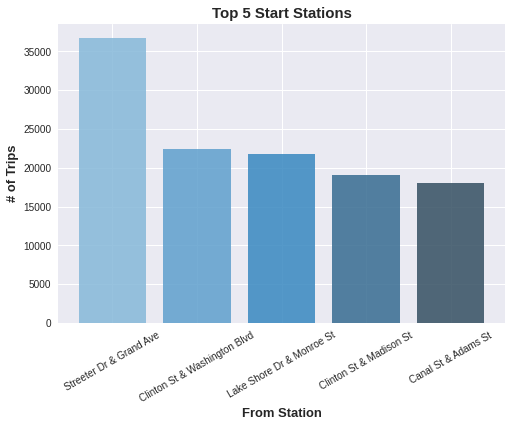

In [64]:
### TODO: your code here

plt.bar(q1.from_station_name,q1.number_of_trips, color =sns.color_palette("Blues_d",5), alpha = 0.85)
plt.xticks(rotation=30)
plt.xlabel('From Station', fontsize = 13, weight = 'bold')
plt.ylabel('# of Trips', fontsize = 13, weight = 'bold')
plt.title('Top 5 Start Stations', fontsize = 15, weight = 'bold')


## Task 2:  Plot the rider performance by Gender and Age based on median speed (distance traveled / trip duration)

Please find the best way to showcase median speed for each gender group and age bin. Feel free to leverage the already created **q2** dataframe or build your solution from scratch.

You can use whatever visualization packages, any other programming languages you prefer or any dashboard software available.



In [65]:
 # check if there's missing value in our dataset
 df.isnull().sum(0) #there missing values for gender and age

Unnamed: 0                0
trip_id                   0
start_time                0
end_time                  0
bikeid                    0
tripduration              0
from_station_id           0
from_station_name         0
to_station_id             0
to_station_name           0
usertype                  0
gender               316856
age                  316672
from_latitude             0
from_longitude            0
to_latitude               0
to_longitude              0
from                      0
to                        0
dis_travel                0
speed                     0
dtype: int64

In [66]:
df = df.dropna() # drop missing value 
df.shape

(1234638, 21)

In [70]:
# Explore age range
# Looks like there're quite a bit of outliers in the dataset
df.age.value_counts().sort_index()

1.0      14
13.0     14
14.0     13
15.0      8
16.0     71
         ..
108.0     9
111.0    26
116.0    41
117.0    97
118.0    52
Name: age, Length: 82, dtype: int64

In [71]:
# Create age bins by removing outliers
df['age_bin'] = pd.cut(df.age, [17,25,35,45,55,65,70],
                       labels=['17-25','25-35','35-45','45-55','55-65', '65-70'])

In [72]:
q4 = df.pivot_table(index=['gender','age_bin'], 
                    values=['speed','dis_travel'],
                    aggfunc={'speed':'median','dis_travel':'mean'}).rename(columns = {'dis_travel':'avg_trip_distance',
                                                                                      'speed':'median_speed'})
q4

avg_trip_distance  median_speed
gender age_bin                                 
Female 17-25             1.247736      6.069781
       25-35             1.287414      6.298900
       35-45             1.262725      6.040337
       45-55             1.137837      5.723989
       55-65             1.064981      5.373917
       65-70             1.007098      4.629357
Male   17-25             1.108933      6.620491
       25-35             1.216929      6.815174
       35-45             1.198648      6.619809
       45-55             1.084570      6.281348
       55-65             1.010389      5.830090
       65-70             0.991131      5.466093

Text(0.5, 1.0, 'Avg Trip Distance')

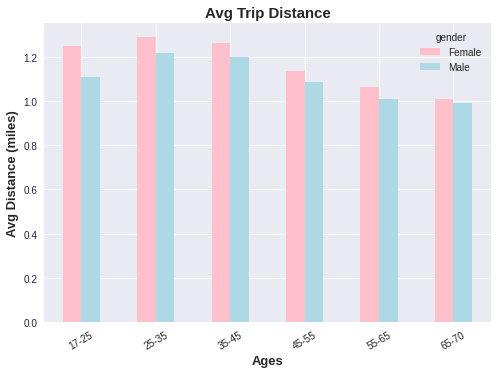

In [73]:
### TODO: your code here

dis = df.pivot_table(index='age_bin', 
               columns='gender', 
               values='dis_travel',aggfunc='mean')
dis.plot.bar(color=['pink','lightblue'])
plt.xticks(rotation=30)
plt.xlabel('Ages', fontsize = 13, weight = 'bold')
plt.ylabel('Avg Distance (miles)', fontsize = 13, weight = 'bold')
plt.title('Avg Trip Distance', fontsize = 15, weight = 'bold')